In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils
import stacked_vae_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.distributions import Categorical

import timeit

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [7]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001, propn_labeled=0.1)

In [8]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


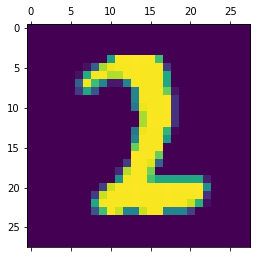

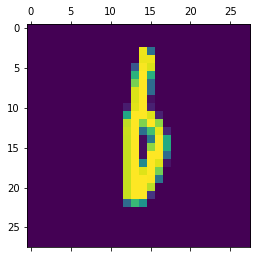

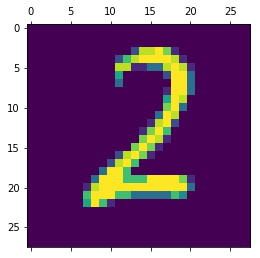

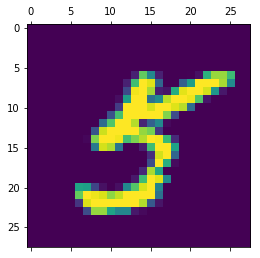

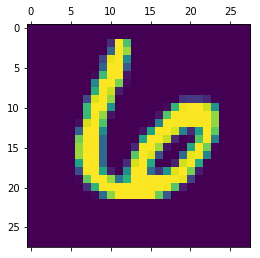

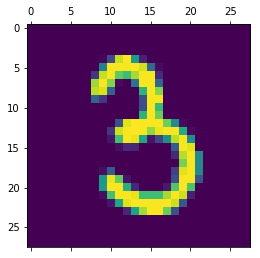

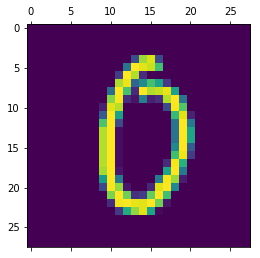

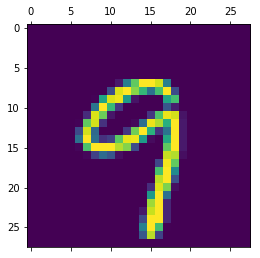

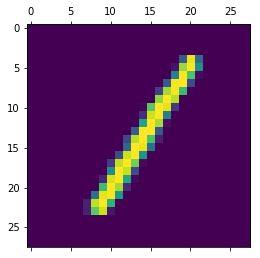

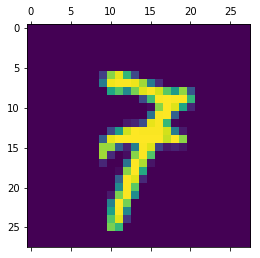

In [9]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

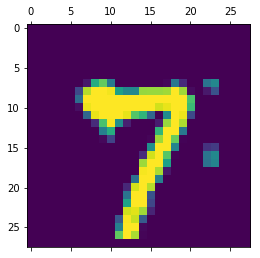

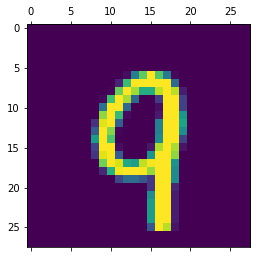

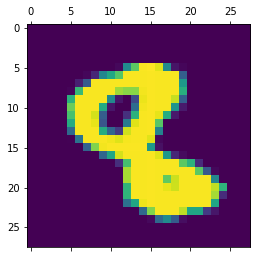

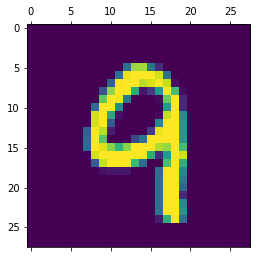

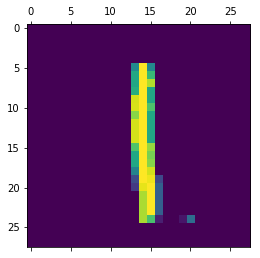

In [10]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())
    assert np.all(test_set[i]['image'].detach().numpy() <= 1)
    assert np.all(test_set[i]['image'].detach().numpy() >= 0)

In [11]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [12]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [13]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [14]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

# Define Model 1VAE

In [18]:
sqrt_latent_dim = 3
latent_dim = sqrt_latent_dim ** 2
n_classes = 10

In [19]:
model1_vae = stacked_vae_lib.Model1VAE(sqrt_latent_dim = sqrt_latent_dim)

NameError: name 'latent_dim' is not defined

In [20]:
print(model1_vae.parameters)

NameError: name 'model1_vae' is not defined

In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

In [15]:
### Check things run

In [16]:
# check dimensions of encoder output

latent_means, latent_std = \
    model1_vae.encoder(data_unlabeled['image'], z = None)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [17]:
recon_mean, _ = \
    model1_vae.decoder(latent_means, z = None)
    
assert recon_mean.shape[0] == batchsize
assert recon_mean.shape[1] == slen
assert recon_mean.shape[2] == slen

In [18]:
model1_vae.loss(data_unlabeled['image'])

tensor(544.0338)

# Check gradient works 

In [19]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [20]:
vae_params0 = get_vae_params(model1_vae)

In [21]:
assert np.any(np.isnan(vae_params0)) == False

In [22]:
optimizer = optim.Adam(model1_vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [23]:
loss = model1_vae.loss(data_unlabeled['image'])

In [24]:
loss.backward()
optimizer.step()

In [25]:
vae_params1 = get_vae_params(model1_vae)

In [26]:
assert np.any(np.isnan(vae_params1)) == False

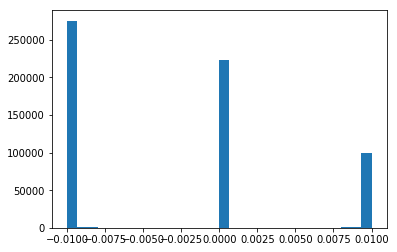

In [27]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [28]:
loss2= model1_vae.loss(data_unlabeled['image'])

In [29]:
assert np.isfinite(loss2.detach().numpy())

In [30]:
model1_vae.train_vae(train_loader_unlabeled, 
                test_loader, 
                n_epoch = 5, print_every = 2, outfile = './test')

  * init train recon loss: 430.0390625;
  * init test recon loss: 431.4534302;
[1] unlabeled_loss: 353.5904846  	[0.1 seconds]
[2] unlabeled_loss: 206.9852753  	[0.0 seconds]
  * train recon loss: 193.5288239;
  * test recon loss: 196.8999329;
[3] unlabeled_loss: 177.629776  	[0.0 seconds]
[4] unlabeled_loss: 145.2473755  	[0.1 seconds]
  * train recon loss: 143.3441772;
  * test recon loss: 141.0462341;
[5] unlabeled_loss: 143.3603058  	[0.1 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final



In [31]:
# Check stacked model

In [32]:
vae = stacked_vae_lib.StackedModelVAE(model1_vae,
                m2_latent_dim = 36,
                n_classes = n_classes)


3
9


TypeError: new() received an invalid combination of arguments - got (numpy.int64, int), but expected one of:
 * (torch.device device)
 * (tuple of ints size, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.int64[0m, [31;1mint[0m)
 * (torch.Storage storage)
 * (Tensor other)
 * (object data, torch.device device)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.int64[0m, [31;1mint[0m)


In [ ]:
torch.sqrt(torch.Tensor([model1_vae.latent_dim]))

In [ ]:
np.sqrt(model1_vae.latent_dim).astype(int)

In [ ]:
round(3.0)